In [1]:
!pip install pennylane --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 78.0 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer,GradientDescentOptimizer

In [3]:
dev = qml.device("default.qubit", wires=6)

In [4]:
def amplitude_encoding(x, wires):
  qml.AmplitudeEmbedding(features=x, wires=wires, normalize=True)

def amplitude_encoding_inverse(x, wires):
  qml.adjoint(qml.AmplitudeEmbedding)(features=x, wires=wires, normalize=True)

In [5]:
def qaoa_ansatz(number_qubit,start_wire, theta):
  '''
  theta_size = 2n
  start_wires = 0 or 4
  '''

  for i in range(number_qubit):
    qml.H(wires=[i+start_wire])
    qml.RY(theta[i], wires=[i+start_wire])
  for i in range(number_qubit):
    c = i
    if c == number_qubit-1:
      f = number_qubit-1
      c = 0
    else:
      f = c+1
    qml.CNOT(wires=[c+start_wire,f+start_wire])
    qml.RZ(theta[number_qubit+i], wires=[f+start_wire])
    qml.CNOT(wires=[c+start_wire,f+start_wire])
# print(qml.draw(qaoa_ansatz)(3,3, [1,2,3,4,5,6,7,8]))


In [6]:
def hardware_effificent_ansatz(number_qubit, theta):
  '''
  theta_size = 2n
  '''
  for i in range(number_qubit):
    qml.H(wires=[i])
    qml.RY(theta[i], wires=[i])
  for i in range(number_qubit):
    c = i
    if c == number_qubit-1:
      f = 0
    else:
      f = c+1
    qml.CRY(theta[number_qubit+i], wires=[c,f])
# print(qml.draw(hardware_effificent_ansatz)(4, [1,2,3,4,5,6,7,8]))

In [7]:
@qml.qnode(dev)
def full_circuit(x, weights):
  '''
  x: input
  weights: [theta1, theta2, theta3, theta4]
  '''
  # step 1: initial state
  # step 2: compute QKSAS
  # first register
  amplitude_encoding(x=x, wires=range(3))
  qaoa_ansatz(number_qubit=3,start_wire=0, theta=weights[0])
  amplitude_encoding_inverse(x=x, wires=range(3))
  qml.adjoint(qaoa_ansatz)(number_qubit=3,start_wire=0, theta=weights[1])

  # second register
  amplitude_encoding(x=x, wires=range(3,6))
  qaoa_ansatz(number_qubit=3,start_wire=3, theta=weights[2])

  # step 3: apply DMP
  # measure M1
  m_10 = qml.measure(0)
  m_11 = qml.measure(1)
  m_12 = qml.measure(2)

  # conditional with wires 3->5, theta4
  qml.cond(m_10, qml.RY)(weights[3][0], wires=3)
  qml.cond(m_11, qml.RY)(weights[3][1], wires=4)
  qml.cond(m_12, qml.RY)(weights[3][2], wires=5)

  # step 4: measure M2 and return
  return qml.expval(qml.PauliZ(3) @ qml.PauliZ(4) @ qml.PauliZ(5))


In [8]:
weights = 0.1 * np.random.randn(4, 6, requires_grad=True)
params = (weights,)

In [9]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

def cost(*args, **kwargs):
    # Extract the parameters and data from *args and **kwargs
    weights = args[0]  # Assuming the first argument is the parameters (usually a NumPy array)
    X = kwargs.get('X', None)  # Get X from kwargs, default to None if not provided
    Y = kwargs.get('Y', None)  # Get Y from kwargs, default to None if not provided

    predictions = [full_circuit(x=x, weights=weights) for x in X]
    return np.mean((Y - qml.math.stack(predictions)) ** 2)

In [10]:
ds= qml.data.load("other", name="downscaled-mnist")

In [11]:
X_test = np.array(ds[0].test["8"]["inputs"])
Y_test = np.array(ds[0].test["8"]["labels"])
X = np.array(ds[0].train["8"]["inputs"])
Y = np.array(ds[0].train["8"]["labels"])

In [12]:
X = X[:500]
Y = Y[:500]
X_test = X_test[:50]
Y_test = Y_test[:50]

In [13]:
print(X.shape)
print(Y.shape)

(500, 8)
(500,)


In [14]:
import matplotlib.pyplot as plt
def draw_result(current_cost_list,acc_list,test_acc_list,epoch,lrate,n_layers=1):
    fig, axs = plt.subplots(3, 1, figsize=(12, 10))
    axs[0].plot(epoch, current_cost_list,label=f'loss_{lrate}')
    axs[0].set_title(f'Loss {n_layers}')
    axs[0].set_xlabel('Epoch')  # Set x-axis label
    axs[0].set_ylabel('Cost Function')  # Set y-axis label
    axs[0].legend()
    axs[1].plot(epoch, acc_list, label=f'train_acc_{lrate}')
    axs[1].set_title(f'Train acc {n_layers}')
    axs[1].set_xlabel('Epoch')  # Set x-axis label
    axs[1].set_ylabel('Train Accuraccy')  # Set y-axis label
    axs[1].legend()
    axs[2].plot(epoch, test_acc_list,label=f'test_acc_{lrate}')
    axs[2].set_title(f'Test acc {n_layers}')
    axs[2].set_xlabel('Epoch')  # Set x-axis label
    axs[2].set_ylabel('Test Accuraccy')  # Set y-axis label
    axs[2].legend()
    fig.subplots_adjust(hspace=0.5)
    fig.tight_layout()
    plt.show()
    fig.savefig(f"/kaggle/working/chart_nlayer{n_layers}_lrate{lrate}.png")

number layers: 1
Iter:    1 | Cost: 1.3938928 | Accuracy: 0.4700000 | Test Accuracy: 0.5600000 | Run Time: 71.8483984
Iter:    2 | Cost: 1.1788750 | Accuracy: 0.5300000 | Test Accuracy: 0.5400000 | Run Time: 70.8423057
Iter:    3 | Cost: 0.9911953 | Accuracy: 0.6020000 | Test Accuracy: 0.5000000 | Run Time: 71.1421702
Iter:    4 | Cost: 0.9680487 | Accuracy: 0.6140000 | Test Accuracy: 0.4800000 | Run Time: 72.0187900
Iter:    5 | Cost: 0.9727583 | Accuracy: 0.6340000 | Test Accuracy: 0.4400000 | Run Time: 70.2973692
Iter:    6 | Cost: 0.9837425 | Accuracy: 0.6300000 | Test Accuracy: 0.4600000 | Run Time: 72.8595285
Iter:    7 | Cost: 0.9973599 | Accuracy: 0.5980000 | Test Accuracy: 0.4800000 | Run Time: 70.9649487
Iter:    8 | Cost: 1.0034364 | Accuracy: 0.5860000 | Test Accuracy: 0.4600000 | Run Time: 71.5387404
Iter:    9 | Cost: 0.9942656 | Accuracy: 0.5840000 | Test Accuracy: 0.4600000 | Run Time: 71.9907928
Iter:   10 | Cost: 0.9699921 | Accuracy: 0.6020000 | Test Accuracy: 0.4400

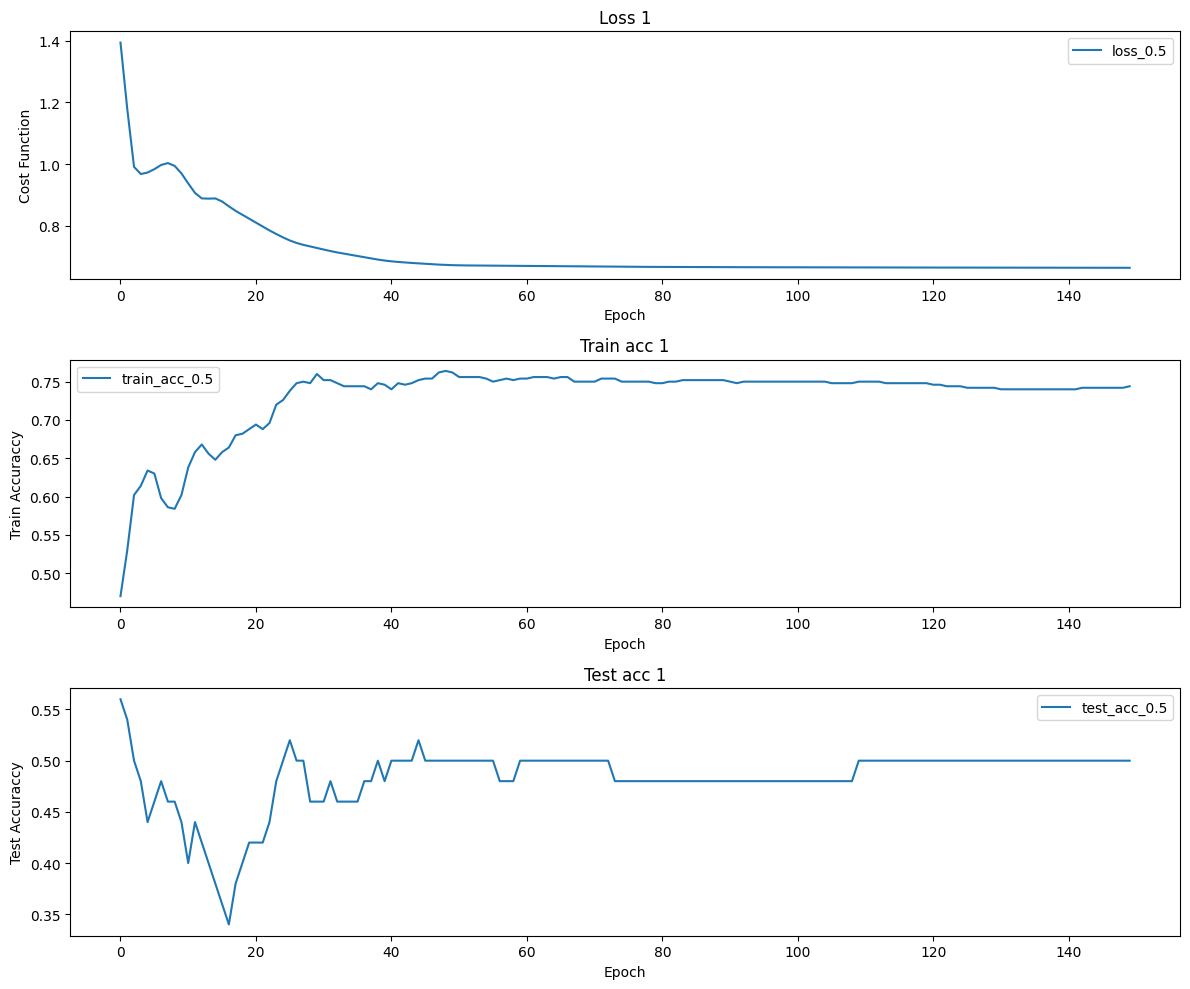

[[-1.52663092 -1.25672026 -0.57408132 -0.19055687 -0.03866313  0.07237764]
 [ 1.47519339 -1.41563275 -1.33985349 -0.04489547  0.00542313  0.35226881]
 [-0.09212578 -1.72802204 -0.47842716 -1.56938796 -1.57110362  1.57041643]
 [ 0.5793151   0.33603668 -1.32835159  0.01021147 -0.02582939  0.01960097]]


In [15]:
import time
learning_rate = [0.5]
num_layers = [1]
for n_layers in num_layers:
    lrate = 0.5
    print("number layers:", n_layers)

    opt = NesterovMomentumOptimizer(lrate)
    current_cost_list = []
    acc_list = []
    test_acc_list = []
    epoch = []
    for it in range(150):
        start_time = time.time()

        # Update the weights by one optimizer step, using only a limited batch of data
        gradient_value, current_cost = opt.compute_grad(objective_fn=cost, args=params, kwargs={"X": X, "Y": Y})
        params = opt.apply_grad(grad=gradient_value, args=params)
        current_cost_list.append(current_cost)
        weights = params[0]
        # Compute accuracy on train
        predictions = [np.sign(full_circuit(x,weights)) for x in X]
        acc = accuracy(Y, predictions)
        acc_list.append(acc)

        # Compute accuracy on test
        predictions_test = [np.sign(full_circuit(x,weights,)) for x in X_test]
        test_acc = accuracy(Y_test, predictions)
        test_acc_list.append(test_acc)
        epoch.append(it)

        # Redraw the updated plot
        end_time = time.time() - start_time
        print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f} | Test Accuracy: {test_acc:0.7f} | Run Time: {end_time:0.7f}")
    draw_result(current_cost_list,acc_list,test_acc_list,epoch,lrate,n_layers)
    print(weights)

In [16]:
# Compute accuracy
weights = params[0]
predictions = [np.sign(full_circuit(x,weights)) for x in X_test]
acc = accuracy(Y_test, predictions)
print(f"Final test, accuracy_test: {acc}")

Final test, accuracy_test: 0.78
